(sec:intro)=
# Uvod v procesiranje signalov

## Kaj je procesiranje signalov?
Termin *procesiranje signalov* uporabljamo za označitev različnih metod obdelave izmerjenih podatkov z namenom, da razkrijemo informacije skritev v takih meritvah.

Kot primer si lahko pogledamo meritve na novem/poškodovanem ležaju (za podrobnosti glejte vir {cite:t}`slavic2011typical`). Slika spodaj prikazuje meritev sile na dobrem in dveh poškodovanih ležajih. V meritvah vidimo določene razlike, ampak ali lahko iz meritev identificiramo *tip* poškodbe? Nadalje ali lahko iz meritev identificiramo *velikost* poškodbe?

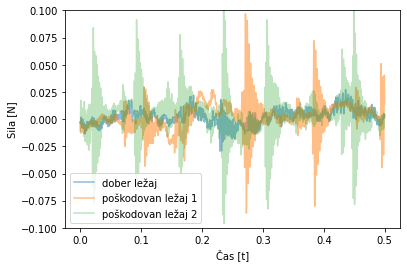

In [52]:
import numpy as np
import matplotlib.pyplot as plt

new = np.load('./data/bearing/new 1A.npy')
radial = np.load('./data/bearing/radial Low 1A.npy')
contamination = np.load('./data/bearing/contam low 2A.npy')
time = np.arange(len(new)) * 1./5000

sel = time<0.5
plt.plot(time[sel], new[sel, 2], alpha=0.5, label='dober ležaj')
plt.plot(time[sel], radial[sel, 2], alpha=0.5, label='poškodovan ležaj 1')
plt.plot(time[sel], contamination[sel, 2], alpha=0.3, label='poškodovan ležaj 2')
plt.xlabel('Čas [t]')
plt.ylabel('Sila [N]')
plt.ylim(-0.1, 0.1)
plt.legend();

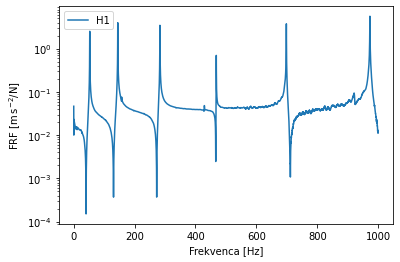

In [54]:
import pyuff

uff = pyuff.UFF('./data/uff/beam.uff').read_sets(setn=4)
fr = uff['x']
H1 = uff['data']

sel = fr<1000
plt.semilogy(fr[sel], np.abs(H1[sel]), label='H1')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('FRF [m$\,$s$^{-2}$/N]')
plt.legend();

## Kaj je proces?

## Kaj je model?

## Kaj linearni, časovno invariantni sistem?

## Kaj je negotovost?

## Zvezni/diskretni popis sistemov

## Klasifikacija podatkov

Tukaj je potrebno povezati vsa poglavja, ki sledijo. Narediti pregle. To se bo naredilo na koncu.

Povezati je treba termine kot so:
* proces
* sistem
* linearni časovno neodvisni sistem
* impulzni odziv
* konvolucija
* Fourierjeva transformacija
* časovna ali frekvenčna domena
* naključni ali deterministični proces

Signal processing deals with the analysis of processes which can in general be [**deterministic**](sec:deterministic) or  [**random**](sec:random). Deterministic process is the process that can (with a reasonable accuracy) be described with an explicit mathematical relation. Random process is a process than cannot be described with an explicit mathematical relation, but requires probability statements and statistical averages.

This chapter will give a general introduction which is required for the following chapters. Greater details can be found in books by {cite:t}`bendat_piersol_random_data_2010`, {cite:t}`shin2008fundamentals`, {cite:t}`newland_1993` and {cite:t}`rice1944mathematical`.

(sec:deterministic)=
## Deterministic process

Deterministic data from a deterministic process is that which can be unambiguously deduced through mathematical relationships and conditions. Values within the sequence, such as a time history, can be successfully extrapolated or predicted, to at least within the tolerable error margin. When considering for instance the measured data from a deterministic dynamic system it is expected that, under equal conditions, the observed repeated system response will always be equal, as is, for example, for a mathematical pendulum, released from the same height.
